In [2]:
# import algos and graphs
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import gzip
import random
import time
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Add parent directory to path so algorithms can be imported
sys.path.append(os.path.abspath("../algorithms"))

# Import algorithms
from greedy import find_maximum_clique_from_dict
from local_search import local_search
from randomized import randomized_max_clique
from local_random import local_random_clique
from simulated_annealing import simulated_annealing_with_restarts
from bron_kerbosch import bron_kerbosch_with_pivot, bron_kerbosch_basic

print("All algorithms imported successfully.")


All algorithms imported successfully.


In [3]:
# import a graph

# --- Step 1: Helper to load .adj file ---
def load_adj_file(path):
    """
    Loads a graph stored in adjacency list format (.adj) and
    returns a dictionary {node: set(neighbors)} suitable for Bron–Kerbosch.
    """
    adj_dict = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if ":" not in line:
                continue
            node, neighbors = line.strip().split(":", 1)
            node = node.strip()
            neighbor_set = set(neighbors.strip().split()) if neighbors.strip() else set()
            adj_dict[node] = neighbor_set
    return adj_dict

# --- Step 2: Load student cooperation graph ---
small_graph_dir = "../data/small_graphs"
all_adj_files = [f for f in os.listdir(small_graph_dir) if f.endswith(".adj")]

if not all_adj_files:
    raise FileNotFoundError(f"No .adj files found in {small_graph_dir}")

chosen_file = random.choice(all_adj_files)
adj_path = os.path.join(small_graph_dir, chosen_file)

print(f"📂 Loading graph from: {adj_path}")
G_dict = load_adj_file(adj_path)
print(f"✅ Graph loaded: {len(G_dict)} vertices ({chosen_file})")

📂 Loading graph from: ../data/small_graphs/les_miserables.adj
✅ Graph loaded: 77 vertices (les_miserables.adj)



🔍 Running Greedy algorithm...

=== Greedy ===
Max Clique Nodes: ['62', '48', '55', '58', '64', '63', '65', '57', '59', '61']
Size: 10
Runtime: 0.0037 sec



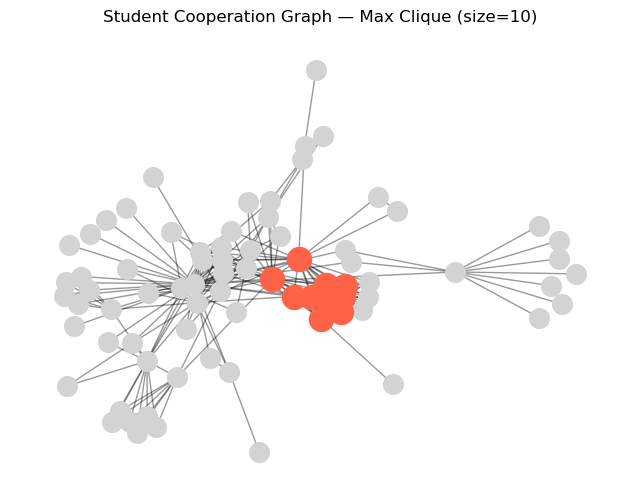

In [4]:
# Greedy
print("\n🔍 Running Greedy algorithm...\n")

start = time.time()
max_clique, runtime = find_maximum_clique_from_dict(G_dict)
end = time.time()

print("=== Greedy ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Local Search algorithm...

=== Local Search ===
Max Clique Nodes: {'59', '63', '65', '64', '55', '57', '61', '58', '48', '62'}
Size: 10
Runtime: 0.0037 sec



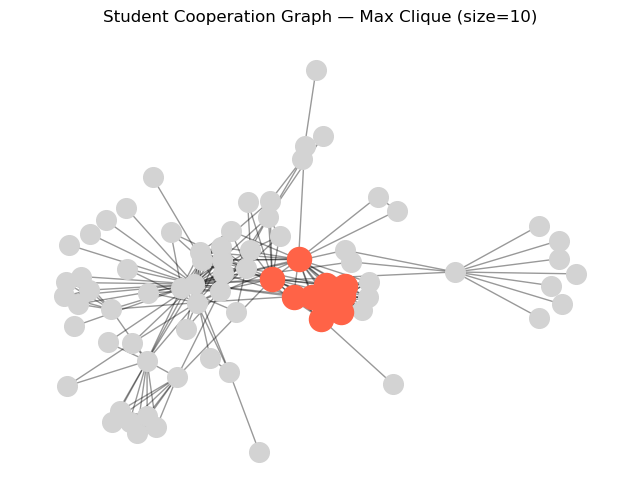

In [5]:
# Local search
print("\n🔍 Running Local Search algorithm...\n")

start = time.time()
max_clique, runtime = local_search(G_dict)
end = time.time()

print("=== Local Search ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Randomized algorithm...

=== Randomized ===
Max Clique Nodes: ['60', '59', '65', '63', '64', '61', '58', '66', '48', '62']
Size: 10
Runtime: 0.0003 sec



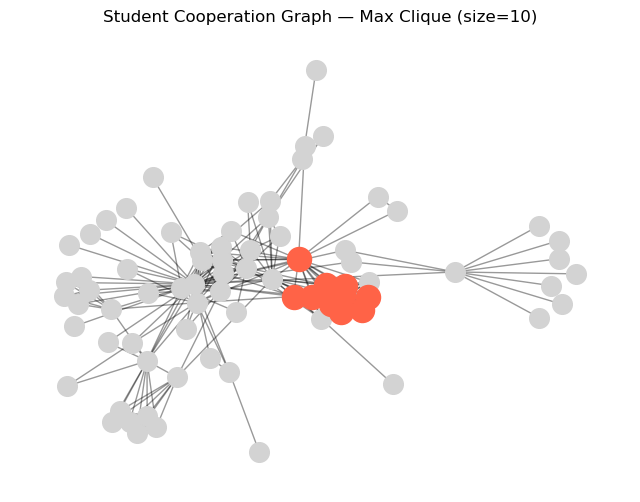

In [7]:
# randomized
print("\n🔍 Running Randomized algorithm...\n")

start = time.time()
size, max_clique, _ = randomized_max_clique(G_dict, restarts=10)
end = time.time()

print("=== Randomized ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Local Random Search algorithm...

=== Local Random Search ===
Max Clique Nodes: {'60', '59', '63', '65', '64', '61', '58', '66', '48', '62'}
Size: 10
Runtime: 0.0293 sec



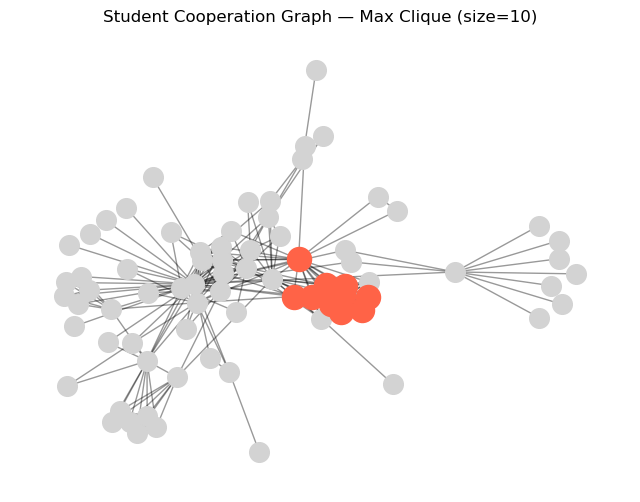

In [6]:
# Local random search
print("\n🔍 Running Local Random Search algorithm...\n")

start = time.time()
max_clique, runtime = local_random_clique(G_dict)
end = time.time()

print("=== Local Random Search ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Simulated Annealing algorithm...

=== Simulated Annealing ===
Max Clique Nodes: {'59', '65', '63', '64', '55', '57', '61', '48', '62'}
Size: 9
Runtime: 0.1904 sec



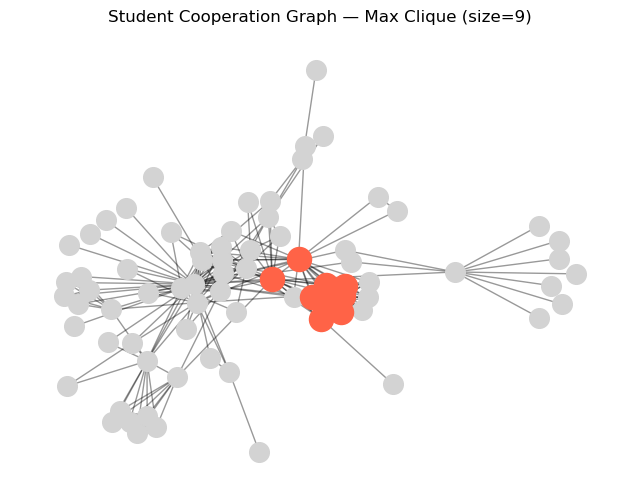

In [8]:
# Simulated Annealing
print("\n🔍 Running Simulated Annealing algorithm...\n")

start = time.time()
max_clique, runtime_sa, _ = simulated_annealing_with_restarts(
    G_dict, # Pass the loaded dictionary graph directly
    initial_temp=1.0, 
    cooling_rate=0.9999,
    max_iterations=10000, 
    num_restarts=5,
    verbose=False
)
end = time.time()

print("=== Simulated Annealing ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Bron–Kerbosch algorithms...

=== Bron–Kerbosch (With Pivoting) ===
Max Clique Nodes: {'60', '59', '65', '63', '64', '61', '58', '66', '48', '62'}
Size: 10
Runtime: 0.0008 sec

=== Bron–Kerbosch (Basic) ===
Max Clique Nodes: {'59', '65', '63', '64', '55', '57', '61', '58', '48', '62'}
Size: 10
Runtime: 0.0025 sec



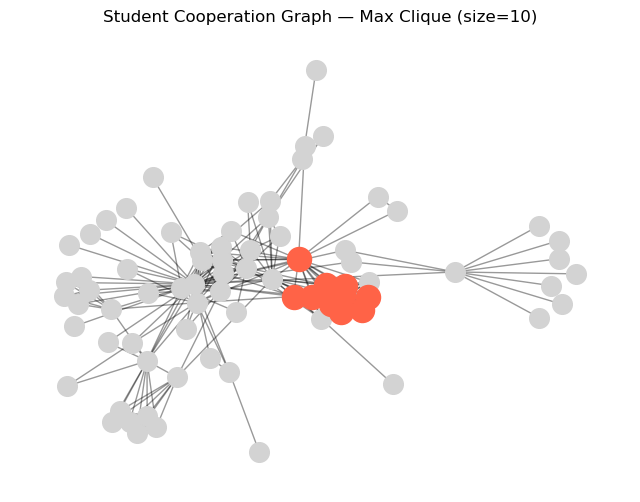

In [9]:
# --- Step 3: Run Bron–Kerbosch (pivoting & basic) ---
print("\n🔍 Running Bron–Kerbosch algorithms...\n")

# With pivot
start_pivot = time.time()
max_clique_pivot, runtime_pivot = bron_kerbosch_with_pivot(G_dict)
end_pivot = time.time()

# Basic
start_basic = time.time()
max_clique_basic, runtime_basic = bron_kerbosch_basic(G_dict)
end_basic = time.time()

# --- Step 4: Display Results ---
print("=== Bron–Kerbosch (With Pivoting) ===")
print(f"Max Clique Nodes: {max_clique_pivot}")
print(f"Size: {len(max_clique_pivot)}")
print(f"Runtime: {end_pivot - start_pivot:.4f} sec\n")

print("=== Bron–Kerbosch (Basic) ===")
print(f"Max Clique Nodes: {max_clique_basic}")
print(f"Size: {len(max_clique_basic)}")
print(f"Runtime: {end_basic - start_basic:.4f} sec\n")

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique_pivot, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique_pivot)})")
plt.axis("off")
plt.show()
